In [1]:
import pandas as pd
import numpy as np

mst = pd.read_csv('mst_data/mst_game.csv')
df = pd.DataFrame()
for i, row in mst.iterrows():
    _df = pd.read_csv(row['csv_file'])
    _df['file_id'] = i
    df = pd.concat([df, _df])
# round当たりのcountが500以上と200以下のものを削除
df = df.groupby(['file_id', 'round']).filter(lambda x: x['round'].count() > 200 and x['round'].count() < 500)

# countを350に統一
df = df.groupby(['file_id', 'round']).tail(200)

# np.arrayに変換
grouped_df = df.groupby(['file_id', 'round'])
grouped_arrays = {name: group.drop(columns=['round', 'timestamp', 'file_id']).values for name, group in grouped_df}

X = np.array(list(grouped_arrays.values()))
Y = np.array([mst.loc[file]['player'] for file, round in list(grouped_arrays.keys())])
X.shape, Y.shape

((105, 200, 99), (105,))

/var/folders/bt/mmlqb6hd6q96zq01wlk8xqk00000gn/T/ipykernel_50510/2553987120.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_smoothed[j, :, i] = pd.Series(X[j, :, i]).rolling(window=window_size).mean().fillna(method='bfill')


(73, 19800) (73,)
Accuracy: 1.0000


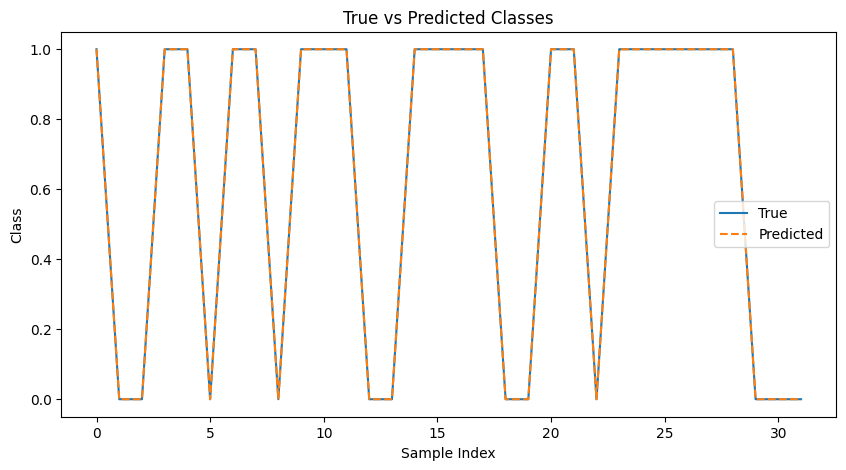

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

n_samples = 105
time_steps = 200
n_features = 99

# 平滑化（移動平均を使用）
window_size = 5
X_smoothed = np.zeros_like(X)

for i in range(n_features):
    for j in range(n_samples):
        X_smoothed[j, :, i] = pd.Series(X[j, :, i]).rolling(window=window_size).mean().fillna(method='bfill')

X_flattened = X_smoothed.reshape(n_samples, -1)

# # 特徴量の抽出（ここでは平均と標準偏差を使用）
# X_features = np.zeros((n_samples, n_features * 2))

# for i in range(n_samples):
#     for j in range(n_features):
#         X_features[i, j] = np.mean(X_smoothed[i, :, j])
#         X_features[i, n_features + j] = np.std(X_smoothed[i, :, j])

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X_flattened, Y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)

# ランダムフォレスト分類器の訓練
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 予測と評価
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(y_pred)), y_pred, label='Predicted', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('True vs Predicted Classes')
plt.legend()
plt.show()


In [4]:
import plotly.graph_objects as go

# 特徴量の重要度を取得
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]  # 重要度が高い順に並べ替え

indices[:10]

array([13853, 16188,  8594, 15524,  1284,  8600, 15370, 16578, 16893,
        6435])

In [6]:
from sklearn.tree import export_graphviz
import graphviz

# 最初の決定木を可視化
estimator = clf.estimators_[0]

# デシジョンツリーの可視化
dot_data = export_graphviz(estimator, out_file=None, 
                           feature_names=[f'feature_{i}' for i in range(X_flattened.shape[1])],
                           class_names=['class_0', 'class_1'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("tree")  # tree.pdfとして保存される

'tree.pdf'

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import graphviz

# ダミーデータの生成
n_samples = 105
time_steps = 200
n_features = 99

# 最初のタイムステップを取得
X_reduced = X[:, 0, :]  # (105, 99)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y, test_size=0.3, random_state=42)

# ランダムフォレスト分類器の訓練
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 予測と評価
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

# 特徴量の重要度を取得
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]  # 重要度が高い順に並べ替え

print(indices[:10])

# 最初の決定木を可視化
estimator = clf.estimators_[0]

# デシジョンツリーの可視化
dot_data = export_graphviz(estimator, out_file=None, 
                           feature_names=[f'feature_{i}' for i in range(X_reduced.shape[1])],
                           class_names=['class_0', 'class_1'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("tree")  # tree.pdfとして保存される


Accuracy: 1.0000
[80 98 92 86 85 91 12 96 90 63]


'tree.pdf'